24 November 2023

Today i try to split data in chronological order and plot predictions vs actual output EGTM

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import numpy as np

In [13]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

Y = dataset[['egtm']]

X = dataset.drop(columns=[
    'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

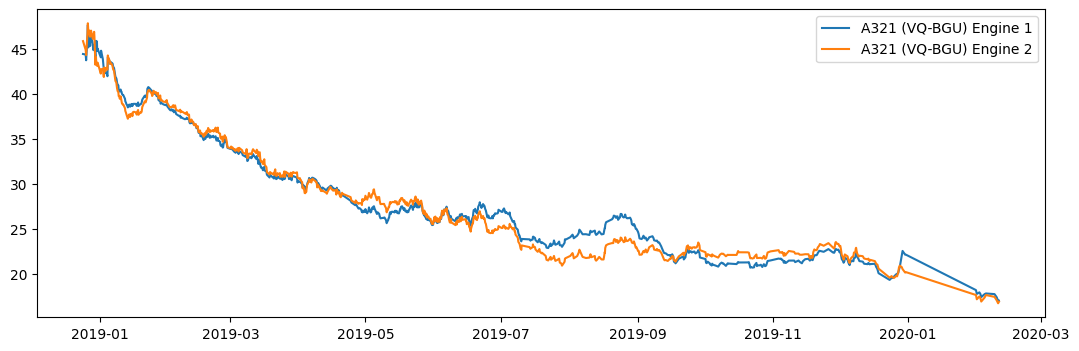

In [19]:
plt.figure(figsize=(13, 4))
d1 = dataset[dataset['pos'] == 1]
plt.plot(d1['reportts'], d1['egtm'], '-')
d2 = dataset[dataset['pos'] == 2]
plt.plot(d2['reportts'], d2['egtm'], '-')
plt.legend(['A321 (VQ-BGU) Engine 1', 'A321 (VQ-BGU) Engine 2'])
plt.show()

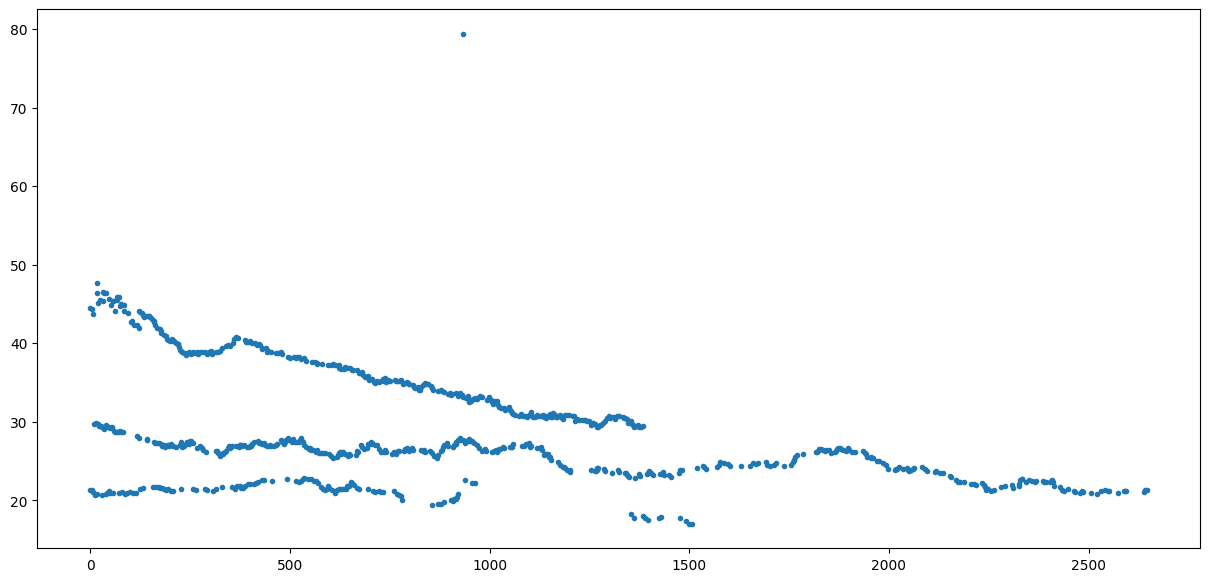

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(d1['ehrs'], d1['egtm'], '.')


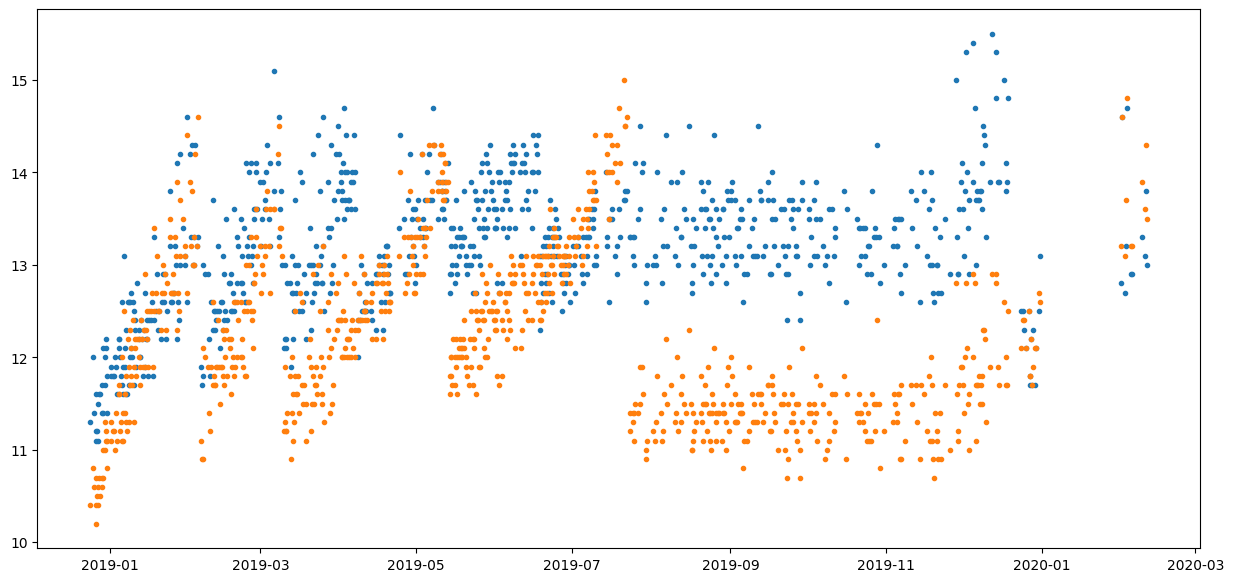

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(d1['reportts'], d1['fdp'], '.')
plt.plot(d2['reportts'], d2['fdp'], '.')

In [21]:
important_features = ['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec', 't2', 'egt', 'egt_peak', 'tat', 'tat_peak']

In [ ]:

def random_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = CatBoostRegressor(iterations=200, random_state=42, verbose=False)
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted, squared=False)
    mae = mean_absolute_error(y_test, predicted)

    print("Test score: RMSE=", mse, "MAE=", mae)

    predicted = model.predict(X_train)
    mse = mean_squared_error(y_train, predicted, squared=False)
    mae = mean_absolute_error(y_train, predicted)

    print("Train score: RMSE=", mse, "MAE=", mae)

    return pd.DataFrame({
        'importance': model.feature_importances_, 
        'feature': X.columns
    }).sort_values('importance', ascending=False)

imp = random_split(X, Y['egtm'])[:15]
# plt.figure(figsize=(10, 4))
# plt.bar(imp['feature'], imp['importance'])
# plt.title('GradientBoosting 15 most important features ')
# plt.show()


Test score: RMSE= 1.2061958590226487 MAE= 0.7901938939213503
Train score: RMSE= 0.3390596689820934 MAE= 0.2690483834788702


In [98]:
len(important_features)

34

Test score: RMSE = 2.238152782824979 MAE = 1.834059310158095
Train score: RMSE = 2.5510953011771487 MAE = 1.9066369238512526
Train size = 428 Test size = 407


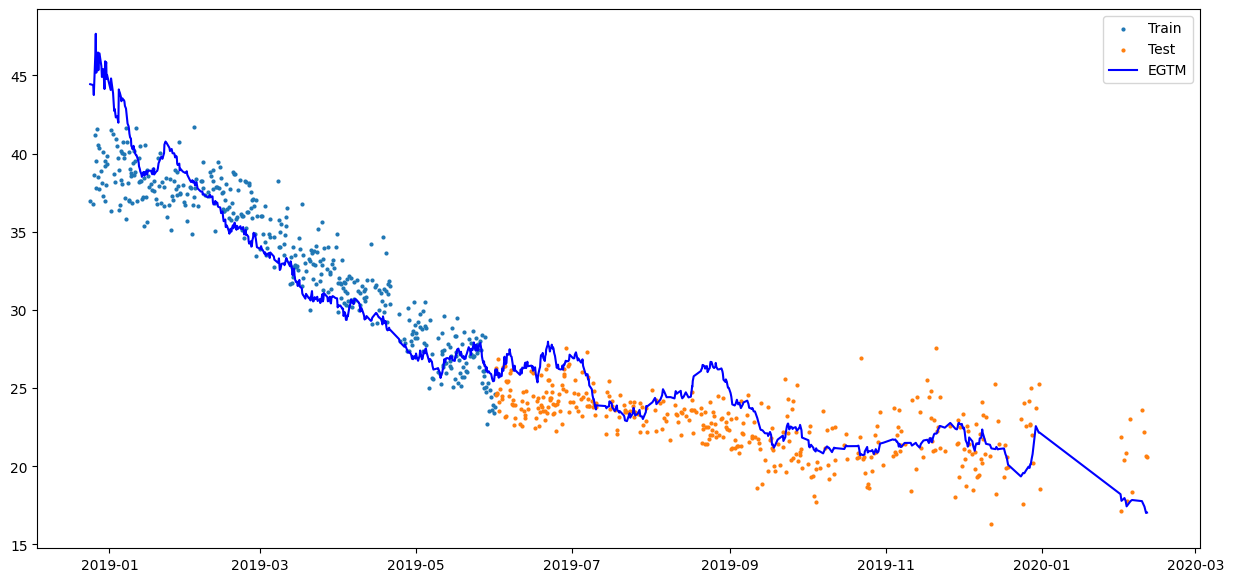

In [97]:
important_features = [
  'naiup', 'hpcbf', 'ff', 'nait', 'fmvc', 'tn', 'p2e', 'sva', 'lpbt', 'gle', 'tfuel', 'tat', 
  'ffr', 'n1p', 'cas', 'vorrc', 'n2c5', 'joip', 'lpt', 'n2a', 'hpctc', 'n2p', 'lpcsv', 'pf', 
  'gw', 'n1c2', 'ttp', 'ps14', 'nai', 'fvd', 'lpctc', 'foc', 'cg', 'w14'
]

def time_split():
    dataset1 = dataset[dataset['pos'] == 1]
    X = dataset1[important_features].fillna(0)
    y = dataset1[['egtm']]
    
    border = '2019-06-01'
    X_train = X.loc[dataset1['reportts'] < border]
    y_train = y.loc[dataset1['reportts'] < border]
    X_test  = X.loc[dataset1['reportts'] >= border]
    y_test  = y.loc[dataset1['reportts'] >= border]

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = Ridge(fit_intercept=True, alpha=100)
    model.fit(X_train, y_train)

    predicted_test = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted_test, squared=False)
    mae = mean_absolute_error(y_test, predicted_test)

    print("Test score: RMSE =", mse, "MAE =", mae)

    predicted_train = model.predict(X_train)
    mse = mean_squared_error(y_train, predicted_train, squared=False)
    mae = mean_absolute_error(y_train, predicted_train)

    print("Train score: RMSE =", mse, "MAE =", mae)
    print("Train size =", len(X_train), "Test size =", len(X_test))

    plt.figure(figsize=(15, 7))
    plt.scatter(dataset1[dataset1['reportts'] < border]['reportts'], predicted_train, s=4)
    plt.scatter(dataset1[dataset1['reportts'] >= border]['reportts'], predicted_test, s=4)
    plt.plot(dataset1['reportts'], dataset1['egtm'], '-', color='blue')
    plt.legend(['Train', 'Test', 'EGTM'])
    plt.show()

time_split()


In [95]:
dataset[important_features]

,naiup,hpcbf,ff,nait,fmvc,tn,p2e,sva,lpbt,gle,...,gw,n1c2,ttp,ps14,nai,fvd,lpctc,foc,cg,w14
0,128.8,13.7,2783.0,4.0,6355.0,41.4,14.902,76.5,239.6,26.0,...,6656.0,79.53,50.0,15.991,0.0,0.10,7.4,7.5,18.6,1160.0
835,127.6,13.7,2775.0,3.0,6133.0,40.3,14.755,77.7,249.8,20.0,...,6656.0,79.59,50.0,15.895,0.0,0.05,8.0,6.4,18.6,1160.0
1,129.0,13.7,3185.0,12.0,7352.0,60.1,14.669,77.3,261.2,29.0,...,7304.0,83.33,54.0,16.026,0.0,0.01,7.7,17.6,22.5,1179.0
836,128.3,13.5,3179.0,12.0,7127.0,57.9,14.471,78.4,271.1,21.0,...,7304.0,83.39,54.0,15.873,0.0,0.01,8.1,17.5,22.5,1179.0
2,132.3,13.8,3637.0,-3.0,8319.0,41.2,14.699,81.1,278.6,29.0,...,8347.0,89.88,36.0,16.482,0.0,0.01,7.8,8.2,26.7,1302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,117.3,14.4,3531.0,-13.0,8132.0,36.0,14.771,78.9,285.1,29.0,...,9031.0,89.04,42.0,16.501,0.0,0.10,7.5,8.1,27.7,1323.0
1668,109.9,13.8,3935.0,0.0,8813.0,54.5,14.567,83.0,278.7,21.0,...,9314.0,91.21,NaN,16.398,0.0,0.04,8.1,6.6,29.3,1305.0
833,117.5,14.2,3969.0,0.0,9066.0,49.3,15.020,81.8,280.6,29.0,...,9314.0,91.15,NaN,16.799,0.0,0.09,7.5,7.7,29.3,1321.0
834,114.7,14.2,3272.0,-5.0,7631.0,44.5,14.717,77.0,273.4,29.0,...,7999.0,85.88,35.0,16.121,0.0,0.01,8.1,8.0,19.1,1247.0


Idea: try regularization with regression